Found 772 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7196
Epoch 1: val_accuracy improved from -inf to 0.67708, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 178s 4s/step - loss: 0.6616 - accuracy: 0.7196 - val_loss: 0.5673 - val_accuracy: 0.6771
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.7579
Epoch 2: val_accuracy did not improve from 0.67708
48/48 [==============================] - 25s 525ms/step - loss: 0.4262 - accuracy: 0.7579 - val_loss: 0.7138 - val_accuracy: 0.3646
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.7500
Epoch 3: val_accuracy did not improve from 0.67708
48/48 [==============================] - 25s 521ms/step - loss: 0.3694 - accuracy: 0.7500 - val_loss: 0.6554 - val_accuracy: 0.5104
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.7619
Epoch 4: val_accuracy did not improve from 0.67708
48/48 [==============================] - 25s 532ms/step - loss: 0.3618 - accuracy: 0.7619 - val_loss: 0.6678 - val_accuracy: 0.4740
Epoch 5/50
48/48 [=====================

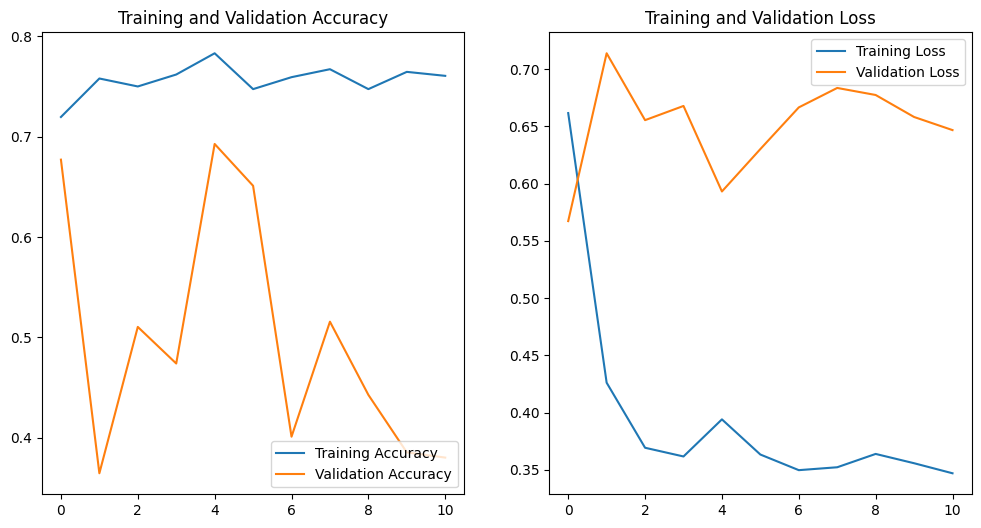

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from PIL import Image, UnidentifiedImageError

# Define path to your dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/data3'

# Image dimensions, batch size, and number of epochs
img_width, img_height = 1024 // 4, 768 //4
batch_size = 16  # Adjusted for data augmentation
epochs = 50

# Setup basic configuration for logging
logging.basicConfig(filename='invalid_images.log', level=logging.ERROR)
++*/
class RobustImageDataGenerator(Sequence):
    def __init__(self, directory, image_data_generator, *args, **kwargs):
        self.directory = directory
        self.generator = image_data_generator.flow_from_directory(directory, *args, **kwargs)
        self.filepaths = self.generator.filepaths
    def __len__(self):

        return int(np.ceil(len(self.filepaths) / self.generator.batch_size))

    def __getitem__(self, idx):
        max_attempts = 10
        attempts = 0
        while attempts < max_attempts:
            try:
                if attempts >= max_attempts - 1:
                    raise Exception("Maximum retry limit reached, all attempts failed.")
                data = next(self.generator)
                return data
            except (tf.errors.InvalidArgumentError, UnidentifiedImageError) as e:
                logging.error(f"Failed to process image: {str(e)}")
                attempts += 1
                # Recalculate the batch index array
                self.adjust_generator()

    def adjust_generator(self):
        valid_indices = []
        for i, filepath in enumerate(self.filepaths):
            try:
                Image.open(filepath)  # Validate the image
                valid_indices.append(i)
            except UnidentifiedImageError:
                continue
        self.generator.index_array = np.array(valid_indices)

    @property
    def samples(self):
        return len(self.filepaths)

# Data preprocessing and augmentation setup
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # 20% of data for validation

# Generators
train_generator = RobustImageDataGenerator(
    data_dir,
    image_data_generator=datagen,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks)

# Save and evaluate the model
model.save('/content/drive/MyDrive/Colab Notebooks/cooked_uncooked_classifier_final.h5')
print("Final model saved")

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)


In [ ]:
import tensorflow as tf
# Load the existing TensorFlow model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/cooked_uncooked_classifier.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a binary file
with open('/content/drive/MyDrive/Colab Notebooks/cooked_uncooked_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted and saved as TensorFlow Lite format.")


Model converted and saved as TensorFlow Lite format.


In [ ]:
import numpy as np
from PIL import Image
import tflite_runtime.interpreter as tflite
import picamera
import picamera.array
import RPi.GPIO as GPIO
import time

# Setup GPIO
GPIO.setmode(GPIO.BCM)
GPIO.setup(18, GPIO.OUT)  # Example pin for output

# Load the TFLite model and allocate tensors
interpreter = tflite.Interpreter(model_path='cooked_uncooked_classifier.tflite')
interpreter.allocate_tensors()

# Get input and output tensors details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image, input_size):
    img = Image.fromarray(image).resize(input_size, Image.ANTIALIAS)
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

# Function to run inference
def run_inference(image):
    input_data = preprocess_image(image, (150, 150))
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = output_data[0][0]
    if pred >= 0.5:
        print(f"Prediction: Cooked with confidence {pred}")
        GPIO.output(18, GPIO.HIGH)  # Example action
    else:
        print(f"Prediction: Uncooked with confidence {1 - pred}")
        GPIO.output(18, GPIO.LOW)  # Example action

# Setup camera
camera = picamera.PiCamera()
camera.resolution = (640, 480)

try:
    # Camera warm-up time
    time.sleep(2)

    with picamera.array.PiRGBArray(camera) as stream:
        while True:
            camera.capture(stream, format='rgb', use_video_port=True)
            image = stream.array
            run_inference(image)
            stream.truncate(0)
            time.sleep(0.1)  # Add delay to avoid overloading the Pi and camera

except KeyboardInterrupt:
    GPIO.cleanup()
    camera.close()
    print("Closed camera and cleaned up GPIO.")

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
